In [1]:
import shutil
from dataclasses import dataclass

from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate

import torch
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms

# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image as PILImage

In [2]:
PATH = Path.home()/'data'/'FERG_DB_256'
PREPARED = PATH/'flatten'

In [3]:
@dataclass
class LabelParser:
    method: str='emotion'
        
    def __post_init__(self):
        if self.method not in ('emotion', 'emotion_char'):
            self.method = 'emotion'
        
    def __call__(self, filename):
        char, emotion, *_ = filename.stem.split('_')
        if self.method == 'emotion':
            return emotion
        else:
            return f'{char}_{emotion}'

In [4]:
files = []
for name in PATH.ls():
    if name.endswith('.txt') or name.startswith('.'):
        continue
    char_dir = PATH/name
    for char_emotion in char_dir.ls():
        emotion_dir = char_dir/char_emotion
        files.extend([fname for fname in emotion_dir.glob('*')])

In [5]:
PREPARED.mkdir(parents=True, exist_ok=True)
for file in files:
    shutil.copy(file, PREPARED/file.name)

In [4]:
img_files = get_image_files(PREPARED)

In [7]:
# ok_files = []
# for file in img_files:
#     try:
#         Image.open(file).convert('RGB')
#         ok_files.append(file)
#     except OSError:
#         print(f'Cannot read file: {file.as_posix()}')

In [5]:
img_files.remove(Path('/home/ck/data/FERG_DB_256/flatten/bonnie_surprise_1389.png'))

In [6]:
parser = LabelParser()
data = ImageDataBunch.from_name_func(
    PREPARED, img_files, parser, ds_tfms=get_transforms(), bs=256, size=224)
data.normalize(imagenet_stats)

In [55]:
data.classes

['neutral', 'surprise', 'fear', 'sadness', 'disgust', 'joy', 'anger']

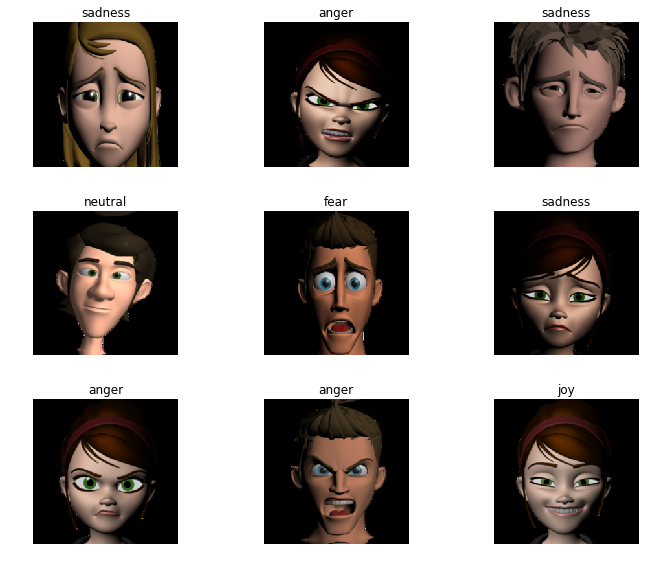

In [7]:
data.show_batch(3, figsize=(10, 8))

In [9]:
learn = ConvLearner(data, models.resnet34, metrics=[accuracy, error_rate])

In [12]:
learn.fit_one_cycle(5)

Total time: 07:57
epoch  train loss  valid loss  accuracy  error_rate
1      0.125606    0.004394    0.999554  0.000446    (01:37)
2      0.012028    0.000472    1.000000  0.000000    (01:35)
3      0.004276    0.000042    1.000000  0.000000    (01:34)
4      0.001465    0.000020    1.000000  0.000000    (01:35)
5      0.000929    0.000010    1.000000  0.000000    (01:35)



In [13]:
learn.save('model')

In [10]:
learn.load('model')

In [17]:
@dataclass
class ConvPredictor:
    
    learn: ConvLearner
    mean: Floats 
    std: Floats
    
    def __post_init__(self):
        self.model_state = self.learn.model.training
        device = self.learn.data.device
        self.mean, self.std = [torch.tensor(x).to(device) for x in (self.mean, self.std)]
        
    def predict(self, x):
        out = self.predict_logits(x)
        best_index = F.softmax(out).argmax()
        return self.learn.data.classes[best_index]
    
    def predict_logits(self, x):
        x = x.to(self.learn.data.device)
        x = normalize(x, self.mean, self.std)
        self.learn.model.eval()
        out = self.learn.model(x[None])
        self.learn.model.train(self.model_state)
        return out
    
    def predict_from_file(self, filename):
        return self.predict(open_image(filename).data)
    
    def show_prediction(self, filename, **kwargs):
        pred_class = self.predict_from_file(filename)
        img = open_image(filename)
        img.show(title=pred_class, **kwargs)

In [18]:
predictor = ConvPredictor(learn, *imagenet_stats)

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


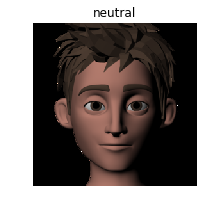

In [19]:
predictor.show_prediction(img_files[0])

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

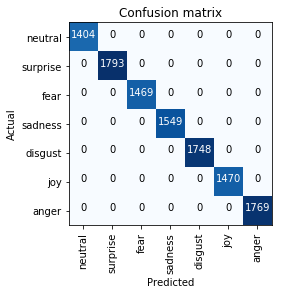

In [24]:
interp.plot_confusion_matrix()

In [28]:
test_img = Path.cwd().parents[1]/'data'/'face.jpg'

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


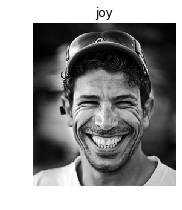

In [63]:
predictor.show_prediction(test_img)

## Facial Expressions from Photos

In [37]:
FACES_DATA = Path.home()/'data'/'facial_expressions'
IMAGES = FACES_DATA/'images'
LABELS = FACES_DATA/'legend.csv'

In [ ]:
IMAGES.rglob('*')

In [41]:
labels = pd.read_csv(LABELS)
labels.drop(columns='user.id', inplace=True)
labels['emotion'] = labels['emotion'].str.lower()
labels.set_index('image', inplace=True)
labels.head()

,emotion
image,
facial-expressions_2868588k.jpg,anger
facial-expressions_2868585k.jpg,surprise
facial-expressions_2868584k.jpg,disgust
facial-expressions_2868582k.jpg,fear
Aaron_Eckhart_0001.jpg,neutral


In [53]:
labels.emotion.unique().tolist()

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [56]:
records = []
for path in IMAGES.rglob('*'):
    if path.name not in labels.index:
        print(f'File emotion is not available: {path.name}')
        continue
    record = {
        'name': path.name,
        'emotion': labels.loc[path.name].emotion, 
        'path': path}
    records.append(record)
faces_df = pd.DataFrame(records)

File emotion is not available: Fernando_Vargas_0004.jpg
File emotion is not available: Rob_Moore_0001.jpg
File emotion is not available: Pedro_Malan_0003.jpg
File emotion is not available: Jiang_Zemin_0007.jpg
File emotion is not available: Padraig_Harrington_0004.jpg
File emotion is not available: Isaiah_Washington_0002.jpg
File emotion is not available: Will_Ferrell_0001.jpg
File emotion is not available: Richard_Gephardt_0007.jpg
File emotion is not available: Morgan_Freeman_0002.jpg
File emotion is not available: Tony_Blair_0090.jpg
File emotion is not available: Hans_Blix_0016.jpg
File emotion is not available: Donald_Rumsfeld_0117.jpg
File emotion is not available: Pierce_Brosnan_0007.jpg
File emotion is not available: Luciano_Pavarotti_0002.jpg
File emotion is not available: Colin_Powell_0048.jpg
File emotion is not available: Jeff_Feldman_0001.jpg
File emotion is not available: Pyar_Jung_Thapa_0001.jpg
File emotion is not available: Robert_Zoellick_0005.jpg
File emotion is not 

In [66]:
sample = faces_df.sample(9)
sample

,emotion,name,path
2216,neutral,Terunobu_Maeda_0001.jpg,/home/ck/data/facial_expressions/images/Teruno...
4285,neutral,Kang_Gum-sil_0001.jpg,/home/ck/data/facial_expressions/images/Kang_G...
1026,happiness,Bilal_Erdogan_0001.jpg,/home/ck/data/facial_expressions/images/Bilal_...
361,sadness,Boris_Becker_0002.jpg,/home/ck/data/facial_expressions/images/Boris_...
8309,happiness,Patsy_Mink_0001.jpg,/home/ck/data/facial_expressions/images/Patsy_...
9242,neutral,Surya_Bahadur_Thapa_0001.jpg,/home/ck/data/facial_expressions/images/Surya_...
8676,neutral,Gordon_Brown_0001.jpg,/home/ck/data/facial_expressions/images/Gordon...
1288,neutral,Al_Cardenas_0001.jpg,/home/ck/data/facial_expressions/images/Al_Car...
3348,surprise,Fernando_Gonzalez_0005.jpg,/home/ck/data/facial_expressions/images/Fernan...


/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


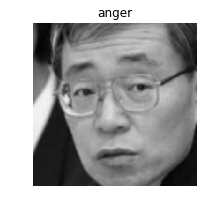

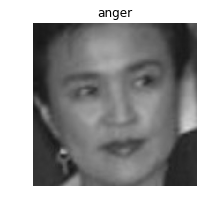

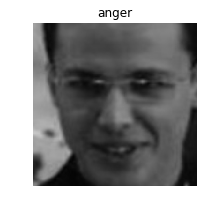

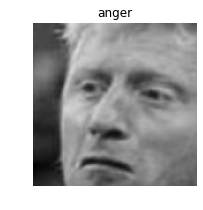

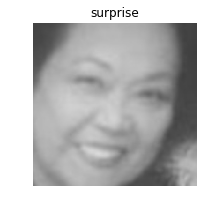

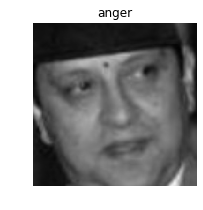

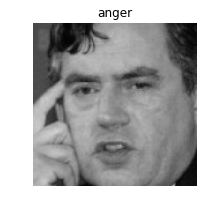

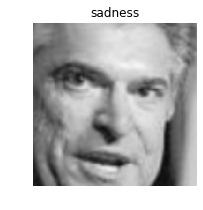

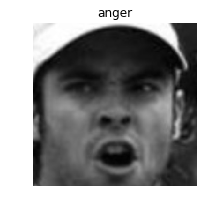

In [67]:
for _, record in sample.iterrows():
    predictor.show_prediction(record.path)